In [1]:
import h5py
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np

import sys 

sys.path.insert(0,'..')
import jabble.dataset
import jabble.loss
import jabble.model

import pickle

In [2]:
sys.path.insert(0,'/Users/matthewdaunt/Documents/pythons/wobble_toys/repos/WobbleSim')
import simulacra.dataset

In [3]:
print(jabble.dataset.velocityfromshift(9e-3)/const.c)

0.00899975700787291


<h1>Intro to Jabble: Fitting EPRVs from Simulacra</h1>
This notebook will give you an introduction to how jabble work by fitting to a dataset generate by Simulacra. Where the EPRVs are precisely known and can be checked for accuracy

In [4]:
data    = simulacra.dataset.from_h5('../../WobbleSim/out/data_e13_a10.0_p7.0_l9.0e+039.3e+03.h5')
epoches = data['data']['flux'].shape[0]

<HDF5 dataset "obs_times": shape (13,), type "|O">


<h2>Jabble Dataset</h2>
Initialize the jabble dataset here using the keys from the h5 file. And we are going to assume none of the data needs to be masked. That will likely change in the future.

In [5]:
import scipy.ndimage
def normalize(flux,sigma):
    return scipy.ndimage.gaussian_filter(flux,sigma=sigma)

In [6]:
masks = np.array(data['data']['mask'],dtype=bool)
wave = np.repeat(np.array(data['data']['wave'])[np.newaxis,:],epoches,axis=0) * u.Angstrom
flux = np.array(data['data']['flux'])
ferr = np.array(data['data']['ferr'])
print(masks.shape)

(13, 6558)


In [8]:
sigma = 80
wob_data = jabble.dataset.WobbleDataset(wave,flux,ferr,masks,normalize,nargs=[sigma])

Now we set the times of observation to be half between the beginning and end of the exposure. In the future this may be a weighted average with the transmission from the telescope.

In [9]:
obs_times = data['data']['obs_times']
exp_times = data['data']['exp_times']
times     = at.Time(obs_times + exp_times/2)
period    = data['parameters']['star']['period']

This part has problems. I don't know how to store the target data. h5 does not seem that it can appropriately save the degree data. And pickle can save it but it won't be able to re read it.

In [10]:
loc    = data['parameters']['detector']['loc']
target = data['parameters']['star']['target']
resolution = float(data['parameters']['detector']['resolution'][()])

The HACK here is literally copying the angle from the other notebook.

In [11]:
loc    = coord.EarthLocation.from_geocentric(loc.value[0] * loc.unit,loc.value[1] * loc.unit,loc.value[2] * loc.unit)
# target = coord.SkyCoord(132.0970782*u.deg, 28.28154327*u.deg )
print(target)

<SkyCoord (ICRS): (ra, dec) in deg
    (225.90437332, 45.62398869)>


In [12]:
bc   = target.radial_velocity_correction(obstime=times,location=loc).to(u.km/u.s)
init_shifts = jabble.dataset.shifts(bc)

<h2>Check the Velocities</h2>
Here we are plotting the theoretical velocities we will be fitting for with Jabble. Just to make sure they make sense. And if our location and target are in the right positions.

In [13]:
import matplotlib.pyplot as plt

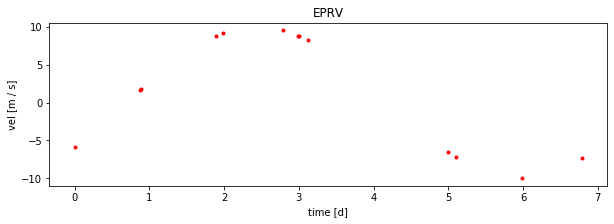

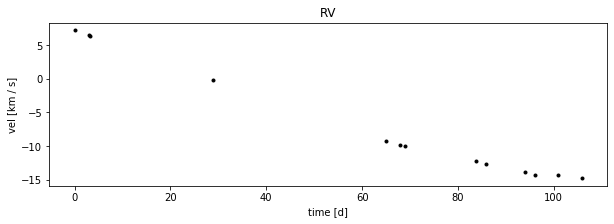

In [14]:
rv = data['data']['rvs'].to(u.km/u.s)
bc  = target.radial_velocity_correction(obstime=times,location=loc).to(u.km/u.s)
eprv = rv - bc

plt.figure(figsize=(10,3))
plt.title('EPRV')
v_unit = u.m/u.s
plt.plot((times - min(times)).to(u.day).value % period.to(u.day).value,eprv.to(v_unit).value,'.r')
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

plt.figure(figsize=(10,3))
plt.title('RV')
v_unit = u.km/u.s
plt.plot((times - min(times)).to(u.day).value,rv.to(v_unit).value,'.k')
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

<h2>Loss Function</h2>
Define the loss function from the jabble.loss module. If the errorbars are too bad, use the L2Loss function.

In [15]:
loss = jabble.loss.L2Loss() #+ jabble.loss.L2Smooth(submodel_ind=[1])

<h2>Create your Jabble Model</h2>
Here we are creating a two part CompositeModel. The first part shifts per epoch, and the second part is a jax linear layer. For the JaxLinear Model you need a set of grid points in x to linearly interpolate into y. So ideally this is set at the resolution or resolutions of the detector. But I guess I could also just use the grid points that were sampled by the detector?

In [16]:
# wave_grid = data['parameters']['detector']['wave_grid']
# x_grid    = np.log(wave_grid.to(u.Angstrom).value)
vel_padding = 50 * u.km/u.s

Now we will only be fitting the linear model first, which is at the position 1 in the list in the CompositeModel

In [17]:
x_grid = jabble.model.create_x_grid(wob_data.xs,vel_padding,resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))
stellar_model = jabble.model.CompositeModel([jabble.model.ShiftingModel(init_shifts),jabble.model.JaxLinear(x_grid)])
stellar_model.fit(1)

<h2>Fitting Time</h2>
Now it's time to fit the model to the data using our loss function. And setting some maxiter to stop early to prevent any overfitting.

In [18]:
maxiter = 128
res1 = stellar_model.optimize(loss,wob_data,maxiter)

In [19]:
print(res1)

      fun: array(113.93438721)
 hess_inv: <3312x3312 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., ..., 0., 0., 0.])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 62
      nit: 42
     njev: 62
   status: 0
  success: True
        x: array([0., 0., 0., ..., 0., 0., 0.])


In [20]:
import scipy.ndimage
def normalize(y,yerr,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y/y_low, yerr/y

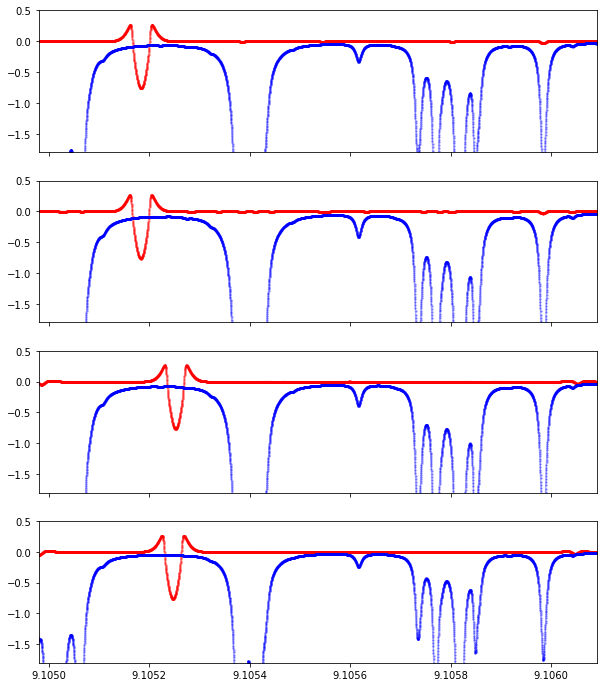

In [28]:
sigma = 80
xpmin = np.log(9000)
xpmax = np.log(9010)
plt_unit = u.Angstrom
plt_epoch = 4
fig, axes = plt.subplots(plt_epoch,figsize=(10,3 *plt_epoch),sharex=True,sharey=True)
for i in range(plt_epoch):
    data.plot_star(axes[i],i,xy='xy',units=plt_unit,normalize=normalize,nargs=[sigma])
    data.plot_tellurics(axes[i],i,xy='xy',units=plt_unit)
    
    axes[i].errorbar(wob_data.xs[i,:],wob_data.ys[i,:],wob_data.yerr[i,:],fmt='.k',elinewidth=0.7,zorder=1,alpha=0.5,ms=6)
    axes[i].plot(stellar_model[1].xs-stellar_model[0].p[i],stellar_model[1].p,'r',linestyle='solid',linewidth=1.1,zorder=2,alpha=0.9,ms=6)
    axes[i].set_xlim(xpmin,xpmax)
    axes[i].set_ylim(-1.8,0.5)
plt.show()

<h2>Grid Search Velocity Shifts</h2>
Now that we have moderately fit the model to the data. We can try a preliminary velocity grid search. First define the velocities to be searched at each epoch. Simply take the init velocities then outer add using some velocity kernel. Here we decide the step size to be: <br>
$$\Delta v = \frac{c}{R}$$

In [22]:
vel_width = 10 * u.km/u.s
vel_step = const.c/resolution/10.
velocity_kern = np.arange(-vel_width.to(u.km/u.s).value,vel_width.to(u.km/u.s).value,vel_step.to(u.km/u.s).value)*u.km/u.s
velocity_grid = np.add.outer(bc,velocity_kern)

shift_grid = jabble.dataset.shifts(velocity_grid)
loss_array = stellar_model[0].grid_search(shift_grid,loss,stellar_model,wob_data)

In [23]:
print(vel_step)

299.792458 m / s


The grid search returns a loss array of the same size as the velocity grid. Now we take the lowest loss of each epoch on these grids along with it's two neighbors, and create a parabola. The minimum of that parabola is used as the new velocity shift.

In [24]:
x_min, x_vals, y_vals, polynomials = jabble.dataset.get_parabolic_min(loss_array,shift_grid,return_all=True)
stellar_model[0].p = x_min

epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 57
epch 3: min 52
epch 4: min 59
epch 5: min 0
minimum likely out of range
epch 6: min 40
epch 7: min 10
epch 8: min 43
epch 9: min 57
epch 10: min 51
epch 11: min 56
epch 12: min 43


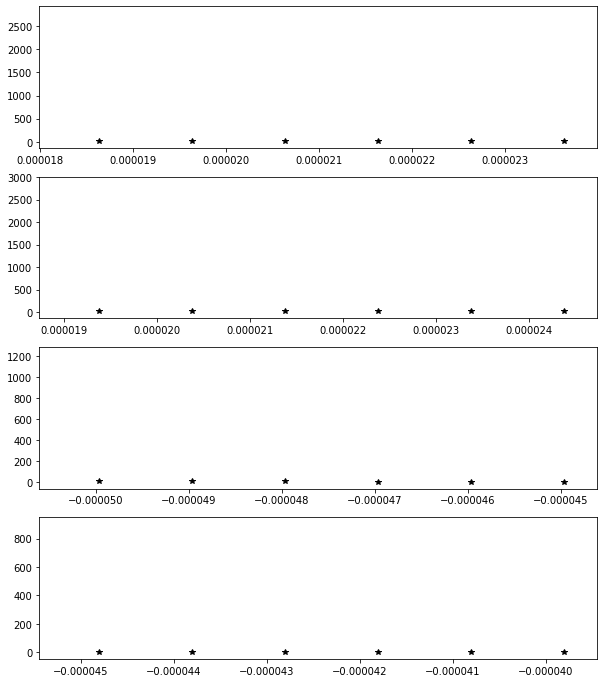

In [25]:
plt_epoch = 4
fig, axes = plt.subplots(plt_epoch,figsize=(10,3 *plt_epoch))
for i in range(plt_epoch):
    axes[i].set_xlim(init_shifts[i]-3*jabble.dataset.shifts(vel_step),init_shifts[i]+3*jabble.dataset.shifts(vel_step))
    axes[i].plot(shift_grid[i,:],loss_array[i,:],'*k')
plt.show()

<h2>Second Round of Fitting</h2>
Now once we have a better velocity estimate, we can fit both the jaxlinear model and the shifting model simultaneously!

In [26]:
stellar_model.fit(0)
stellar_model.fit(1)
maxiter = 32
res2 = stellar_model.optimize(loss,wob_data,maxiter)

These finals velocities will be compared with the known values from Simulacra.

In [27]:
final_vels = jabble.dataset.velocityfromshift(stellar_model[0].p)

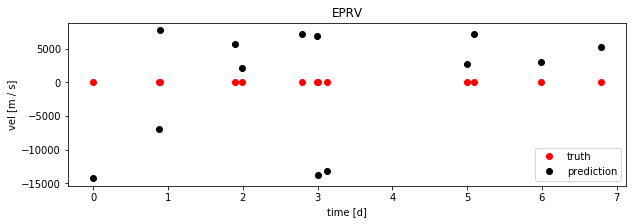

In [29]:
plt.figure(figsize=(10,3))
plt.title('EPRV')
v_unit = u.m/u.s

plt.plot((times - min(times)).to(u.day).value % period.value,(rv-bc).to(v_unit).value,'or',label='truth')
plt.plot((times - min(times)).to(u.day).value % period.value,(final_vels-bc).to(v_unit).value,'ok',label='prediction')

plt.legend()
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()


# plt.ylim(-1,1)